# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Проект-для-«Викишоп»" data-toc-modified-id="Проект-для-«Викишоп»-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Проект для «Викишоп»</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Тест-на-адекватность-моделей" data-toc-modified-id="Тест-на-адекватность-моделей-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Тест на адекватность моделей</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-градиентного-бустинга---CatBoost" data-toc-modified-id="Модель-градиентного-бустинга---CatBoost-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Модель градиентного бустинга - CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></li></ul></div>

## Подготовка

In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer 
import re 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier


Выгрузим данные:

In [2]:
try: 
    df = pd.read_csv('/datasets/toxic_comments.csv')
except: 
    df = pd.read_csv('datasets/toxic_comments.csv')

Посмотрим данные:

In [3]:
display(df.head(10))
df.info()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Объявим корпус текстов, переведем его в тип юникод:

In [4]:
corpus = df['text'].values.astype('U')
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


Объявим лемматизатор и функцию для очистки и лемматизации текстов "clear_text":

In [5]:
wnl = WordNetLemmatizer()

def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = pattern.split()
    lemm = []
    for i in range(len(clear)):
        lemm.append(wnl.lemmatize(clear[i]))
    return " ".join(lemm)

В цикле применим функцию для очистки и лемматизации текстов "clear_text":

In [6]:
for i in tqdm(range(len(corpus))):
    corpus[i] = clear_text(corpus[i])

100%|██████████| 159571/159571 [01:17<00:00, 2053.39it/s]


Объединим датасет и корпус:

In [7]:
df_corpus = pd.DataFrame(corpus)
df['lemm_text'] = df_corpus[0]
display(df.head(10))
df.info()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations from me a well use the tool we...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,Sorry if the word nonsense wa offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
text         159571 non-null object
toxic        159571 non-null int64
lemm_text    159571 non-null object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


Определим количество объектов мажорного и минорного классов и для наглядности строим график:

0    143346
1     16225
Name: toxic, dtype: int64


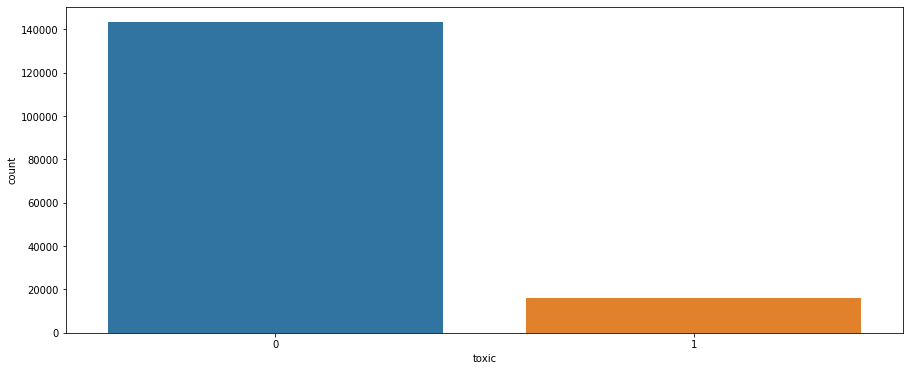

In [8]:
print(df['toxic'].value_counts())
zeroes = df['toxic'].value_counts()[0]
ones = df['toxic'].value_counts()[1]

plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=df)

Определяем признаки и целевой признак, разделяем датасет на тренировочную и тестовую выборки:

In [9]:
features = df['lemm_text']
target = df['toxic']

features_train_1, features_test_1, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

Сделаем стоп-слова и векторизацию текста:

In [10]:
try:
    nltk.download('stopwords')
except:
    pass
#Объявляю набор стоп-слов 
try:
    stopwords = set(stopwords.words('english'))
except:
    pass
#Объявляю TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
#Выполняю векторизацию текстов
features_train = count_tf_idf.fit_transform(features_train_1)
features_test = count_tf_idf.transform(features_test_1)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Оцениваем результаты:

In [11]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(119678, 139462)
(39893, 139462)
(119678,)
(39893,)


Отдельно слелаем набор фичей и таргетов для обучения CatBoost с меньшим количеством так как CatBoost у меня падал с Dead Kernel из-за перегрузки ядра,при обучении модели пришлось уменьшить количество строк в десятки раз, чтобы хоть както обучить модель на локальной машине!!!

In [12]:
features_train_cb = features_train_1[:900]
features_test_cb = features_test_1[:300]
target_train_cb = target_train[:900]
target_test_cb = target_test[:300]

In [13]:
try:
    nltk.download('stopwords')
except:
    pass
#Объявляю набор стоп-слов 
try:
    stopwords = set(stopwords.words('english'))
except:
    pass
#Объявляю TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
#Выполняю векторизацию текстов
features_train_cb = count_tf_idf.fit_transform(features_train_cb)
features_test_cb = count_tf_idf.transform(features_test_cb)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
print(features_train_cb.shape)
print(features_test_cb.shape)
print(target_train_cb.shape)
print(target_test_cb.shape)

(900, 7371)
(300, 7371)
(900,)
(300,)


### Вывод:
   На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк.
   Исходный датасет состоит из следующих столбцов: 
- text — текст комментария; 
- toxic — является ли комментарий токсичным (1) или нет (0) 
- Пропуски в данных отсутствуют.

    После открытия датасета и ознакомления с общей информацией объявлен корпус текстов и переведен в тип юникод. Затем тексты были очищены и лемматизированы. 
    Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. Мажорный класс составляет лишь 10% от всего датасета. Следовательно этот аспект необходимо будет учесть в дальнейшем при обучении моделей. 
    Для векторизации текстов был использован TfidfVectorizer(). После векторизации датасет образовал матрицу размером 159571 строк на 164272 столбцов.

В итоге полученный датасет разделен на обучающую и тестовые выборки в соотношении 4:1.
Можно приступать к обучению моделей.

## Обучение

В качестве моделей будем использовать Логистическую регрессию, Случайный лес и CatBoost классификатор.

### Тест на адекватность моделей

Для надлежащей проверки моделей на адекватность, данные константной модели будут набором единиц.

In [15]:
const_model = [1 for i in range(len(target_test))]
const_f1 = f1_score(target_test.reset_index(drop=True), const_model)
print(const_f1)

0.18457757855696372


### Логистическая регрессия

In [16]:
%%time
#Обучаю и проверяю Логистическую регрессию на кросс-валидации, указываю параметр class_weight = 'balanced'
regression = LogisticRegression(fit_intercept=True, 
                                class_weight='balanced', 
                                random_state=42,
                                solver='liblinear'
                               )
#Определяю словарь с набором параметров
regression_parametrs = {'C': [0.1, 1, 10]}

#Применяю GridSearchCV с кросс-валидацией
regression_grid = GridSearchCV(regression, regression_parametrs, scoring='f1', cv=3)
regression_grid.fit(features_train, target_train)

regression.fit(features_train, target_train)
regression_cv_score = cross_val_score(regression,features_train, target_train,scoring='f1',cv=3).mean()
print('Среднее качество модели Логистической регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели Логистической регрессии на кросс-валидации: 0.7442037383361634
CPU times: user 1min 14s, sys: 1min 53s, total: 3min 7s
Wall time: 3min 8s


Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [17]:
%%time

regression_params = regression_grid.best_params_
regression_score = regression_grid.score(features_train, target_train)
print(regression_params)
print(regression_score)
print('_______________')

{'C': 10}
0.9161026881923703
_______________
CPU times: user 66.6 ms, sys: 1.59 ms, total: 68.2 ms
Wall time: 81.6 ms


Проверяем Логистическую регрессию на тестовой выборке:

In [18]:
%%time

regression_model = LogisticRegression(fit_intercept=True,
                                class_weight='balanced',
                                random_state=42,
                                solver='liblinear',
                                C=regression_params['C']
                               )

regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

CPU times: user 12 s, sys: 16.6 s, total: 28.6 s
Wall time: 28.7 s


Определяем метрику f1:

In [19]:
regression_predictions = regression_model.predict(features_test)
regression_f1 = round(f1_score(target_test, regression_predictions), 3) 
print(regression_f1)

0.763


### Случайный лес

In [20]:
%%time
#Подбираю оптимальные гиперпараметры для Случайного леса на кросс-валидации, указываю параметр class_weight = 'balanced'
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1 )
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(20, 40, 5),
                     'max_depth': range(4, 8, 2),
                     'min_samples_leaf': range(3,5),
                     'min_samples_split': range(2,6,2)}

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring='f1', cv=3)
forest_grid.fit(features_train, target_train)

CPU times: user 5min 20s, sys: 0 ns, total: 5min 20s
Wall time: 5min 26s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                               

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [21]:
%%time
forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 35}
0.3191659481069217
_______________
CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.38 s


Обучаем модель Случайного леса на оптимальных гиперпараметрах:

In [22]:
%%time

forest_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced',
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.86 s


Определяем метрику f1:

In [23]:
forest_predictions = forest_model.predict(features_test)
forest_f1 =  round(f1_score(target_test, forest_predictions), 3)
print(forest_f1)

0.296


### Модель градиентного бустинга - CatBoost

Объявляем модель с учетом дисбаланса классов, пределяем словарь с набором параметров, применяем GridSearchCV с кросс-валидацией:

In [24]:
%%time
import catboost as cb #Импортирую CatBoost т.к. даже при стартовом инстале иногда пакет слетает

#Объявляю модель с учетом дисбаланса классов
cb = cb.CatBoostClassifier(class_weights=[1, zeroes/ones], iterations=30)
#Определяю словарь с набором параметров
cb_parametrs = {'depth': [4, 8]}

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='f1', cv=3)
cb_grid.fit(features_train_cb, target_train_cb, verbose=10)

Learning rate set to 0.329626
0:	learn: 0.6815956	total: 79.9ms	remaining: 2.32s
10:	learn: 0.4700579	total: 433ms	remaining: 748ms
20:	learn: 0.3755928	total: 753ms	remaining: 323ms
29:	learn: 0.2406593	total: 1.13s	remaining: 0us
Learning rate set to 0.329781
0:	learn: 0.6588214	total: 12.6ms	remaining: 366ms
10:	learn: 0.4517795	total: 375ms	remaining: 648ms
20:	learn: 0.3569584	total: 707ms	remaining: 303ms
29:	learn: 0.2267826	total: 1.08s	remaining: 0us
Learning rate set to 0.329937
0:	learn: 0.6709954	total: 12.6ms	remaining: 365ms
10:	learn: 0.4559496	total: 378ms	remaining: 654ms
20:	learn: 0.3695698	total: 786ms	remaining: 337ms
29:	learn: 0.2309431	total: 1.16s	remaining: 0us
Learning rate set to 0.329626
0:	learn: 0.6796779	total: 193ms	remaining: 5.58s
10:	learn: 0.4205947	total: 2.1s	remaining: 3.62s
20:	learn: 0.3078062	total: 3.92s	remaining: 1.68s
29:	learn: 0.1354610	total: 5.66s	remaining: 0us
Learning rate set to 0.329781
0:	learn: 0.6561159	total: 165ms	remaining: 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f8573ca23d0>,
             iid='warn', n_jobs=None, param_grid={'depth': [4, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

CatBoost у меня падал с Dead Kernel из-за перегрузки ядра,при обучении модели пришлось уменьшить количество строк в десятки раз, чтобы хоть както обучить модель на локальной машине!!!

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [25]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train_cb, target_train_cb)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 4}
0.9528795811518325
_______________
CPU times: user 61.2 ms, sys: 8.34 ms, total: 69.5 ms
Wall time: 52.3 ms


Обучаем модель на оптимальных гиперпараметрах и определяем метрику f1:

In [26]:
%%time
import catboost as cb #Импортирую CatBoost т.к. даже при стартовом инстале иногда пакет слетает

cb_model = cb.CatBoostClassifier(class_weights=[1, zeroes/ones], depth=cb_params['depth'], iterations=50)
cb_model.fit(features_train_cb, target_train_cb, verbose=10)
cb_model_predictions = cb_model.predict(features_test_cb)

cb_f1 = round(f1_score(target_test_cb, cb_model_predictions), 3)
print(cb_f1)

Learning rate set to 0.234635
0:	learn: 0.6616787	total: 19.5ms	remaining: 953ms
10:	learn: 0.5150977	total: 547ms	remaining: 1.94s
20:	learn: 0.4485751	total: 1.13s	remaining: 1.56s
30:	learn: 0.3813302	total: 1.63s	remaining: 999ms
40:	learn: 0.2767559	total: 2.19s	remaining: 481ms
49:	learn: 0.2163659	total: 2.7s	remaining: 0us
0.593
CPU times: user 2.93 s, sys: 674 ms, total: 3.61 s
Wall time: 4.62 s


Создадим итоговую таблицу:

In [28]:
columns = ['Модель', 'Время работы модели, сек.', 'f1-мера']
const_model = ['Константная модель', 0, const_f1]
regression_model = ['Логистическая регрессия', 26.1, regression_f1]
forest_model = ['Случайный лес', 2.5, forest_f1]
cd_model = ['CatBoostRegressor', 4.6, cb_f1]

table = pd.DataFrame([const_model, regression_model, forest_model, cd_model], columns = columns)
table['Качество по отношению к константной модели, %'] = round((table['f1-мера']/const_f1) * 100, 2)

display(table)

,Модель,"Время работы модели, сек.",f1-мера,"Качество по отношению к константной модели, %"
0,Константная модель,0.0,0.184578,100.00
1,Логистическая регрессия,26.1,0.763000,413.38
2,Случайный лес,2.5,0.296000,160.37
3,CatBoostRegressor,4.6,0.593000,321.27


## Выводы

    На первом этапе произведена загрузка данных и их подготовка для обучения моделей. 
    Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк. 
    Затем тексты комментариев были очищены и лемматизированы. 
    Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. Мажорный класс составляет лишь 10% от всего датасета. 
    После векторизации датасет образовал матрицу размером 159571 строк на 164272 столбцов. В итоге полученный датасет разделен на обучающую и тестовые выборки в соотношении 4:1.

    В качестве моделей использованы Логистическая регрессия, Случайный лес и CatBoost классификатор. 
    По результатам подбора гиперпараметров и обучения моделей наилучший результат показал CatBoost классификатор, наихудший - Случайный лес. Все выбранные модели прошли проверку на адекватность в сравнении с константной моделью. Результаты сведены в таблицу. Стоит отметить, что CatBoost классификатор выполняет расчеты в десятки раз дольше, нежели Логистическая регрессия, полученное при этом значение метрики f1 ниже, чем у Логистической регрессии, возможно при увеличении количества итераций мы получим результат будет стремиться к логистической регрессии и может быть лучше, но и количество времени на обучение мы потратим колосальное.
    В связи с этим модели Логистическая регрессия и CatBoost классификатор подходят для решения поставленной задачи. Однако, для экономии времени и вычислителной мощности Логистическая регрессия является оптимальным решением для данной задачи.    